<a href="https://www.kaggle.com/code/keremkundak/mnist-ensemble-learning?scriptVersionId=217239378" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-original/mnist-original.mat


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
# Load MNIST dataset
#mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

from scipy.io import loadmat
mnist = loadmat("/kaggle/input/mnist-original/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]
X, y = mnist_data, mnist_label.astype(np.uint8)

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=50000, random_state=42)

In [4]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (50000, 784)
Validation set: (10000, 784)
Test set: (10000, 784)


In [5]:
# Initialize classifiers with carefully tuned hyperparameters
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5, 
        random_state=42,
        n_jobs = -1
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
    ),
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        C=0.1, 
        max_iter=1000, 
        random_state=42,
        n_jobs = -1
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate='adaptive',
        max_iter=500,
        random_state=42
    ),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        algorithm='auto',
        p=2,
        n_jobs = -1
    )
}

In [6]:
# Dictionary to store classifier performances
classifier_performances = {}

print("\nIndividual Classifier Performances:")

# Train and evaluate each classifier on validation set
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    val_pred = clf.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, val_pred)
    
    # Store performance
    classifier_performances[name] = val_accuracy
    
    print(f"{name} Validation Accuracy: {val_accuracy:.4f}")


Individual Classifier Performances:
Random Forest Validation Accuracy: 0.9664
Decision Tree Validation Accuracy: 0.8561
Logistic Regression Validation Accuracy: 0.9191
MLP Validation Accuracy: 0.9748
Naive Bayes Validation Accuracy: 0.5347
KNN Validation Accuracy: 0.9453


In [7]:
# Create soft voting ensemble
soft_voting_clf = VotingClassifier(
    estimators=[(name, clf) for name, clf in classifiers.items()],
    voting='soft')

In [8]:
# Train and evaluate soft voting ensemble
soft_voting_clf.fit(X_train_scaled, y_train)
soft_val_pred = soft_voting_clf.predict(X_val_scaled)
soft_val_accuracy = accuracy_score(y_val, soft_val_pred)
classifier_performances['Soft Voting Ensemble'] = soft_val_accuracy

In [9]:
# Create hard voting ensemble
hard_voting_clf = VotingClassifier(
    estimators=[(name, clf) for name, clf in classifiers.items()],
    voting='hard')

In [10]:
# Train and evaluate hard voting ensemble on validation set
hard_voting_clf.fit(X_train_scaled, y_train)
hard_val_pred = hard_voting_clf.predict(X_val_scaled)
hard_val_accuracy = accuracy_score(y_val, hard_val_pred)
classifier_performances['Hard Voting Ensemble'] = hard_val_accuracy

In [11]:
print(f"Soft Voting Ensemble Validation Accuracy: {soft_val_accuracy:.4f}")
print(f"Hard Voting Ensemble Validation Accuracy: {hard_val_accuracy:.4f}")

Soft Voting Ensemble Validation Accuracy: 0.9646
Hard Voting Ensemble Validation Accuracy: 0.9663


In [12]:
# Sort classifiers by their validation accuracy
sorted_performances = sorted(
    classifier_performances.items(), 
    key=lambda x: x[1], 
    reverse=True)

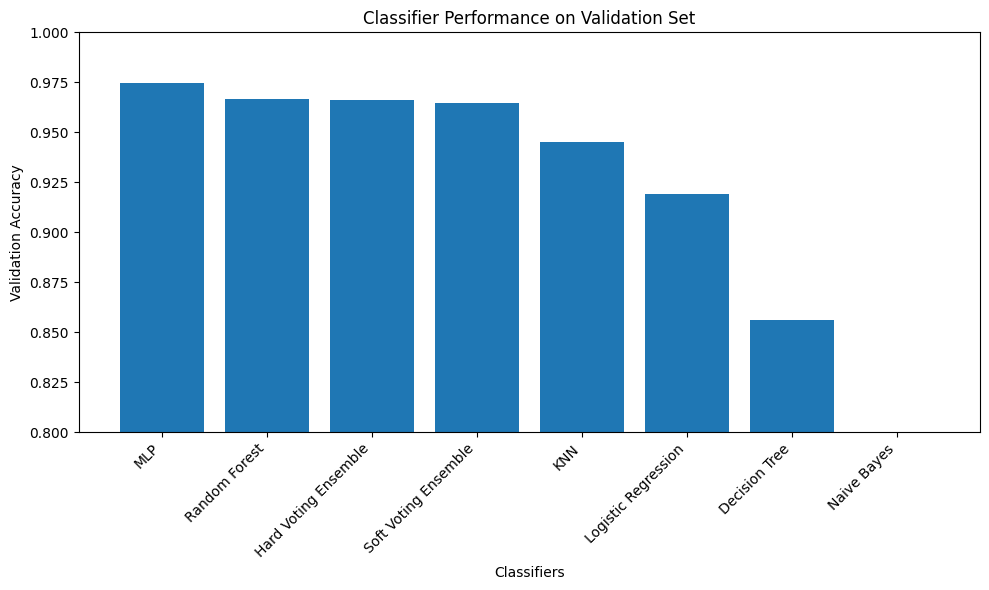

In [13]:
# Create a bar plot of classifier performances
plt.figure(figsize=(10, 6))
names, accuracies = zip(*sorted_performances)
plt.bar(names, accuracies)
plt.title('Classifier Performance on Validation Set')
plt.xlabel('Classifiers')
plt.ylabel('Validation Accuracy')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h3>The ensemble model could not outperform the other individual models. Let's try again by removing the decision tree, logistic regression and naive bayes classifiers that have low accuracy rates.</h3>


In [14]:
# Updated classifiers dictionary
updated_classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5, 
        random_state=42,
        n_jobs = -1
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        algorithm='auto',
        p=2,
        n_jobs = -1
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(100, 50),  
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate='adaptive',
        max_iter=500,
        random_state=42
    )
}

In [15]:
# Update soft voting Ensemble
soft_voting_clf = VotingClassifier(
    estimators=[(name, clf) for name, clf in updated_classifiers.items()],
    voting='soft'
)

# Update hard voting Ensemble
hard_voting_clf = VotingClassifier(
    estimators=[(name, clf) for name, clf in updated_classifiers.items()],
    voting='hard'
)

In [16]:
# Train and evaluate updated soft voting ensemble on validation set
soft_voting_clf.fit(X_train_scaled, y_train)
soft_val_pred = soft_voting_clf.predict(X_val_scaled)
soft_val_accuracy = accuracy_score(y_val, soft_val_pred)
classifier_performances['Updated Soft Voting Ensemble'] = soft_val_accuracy

In [17]:
# Train and evaluate updated hard voting ensemble on validation set
hard_voting_clf.fit(X_train_scaled, y_train)
hard_val_pred = hard_voting_clf.predict(X_val_scaled)
hard_val_accuracy = accuracy_score(y_val, hard_val_pred)
classifier_performances['Updated Hard Voting Ensemble'] = hard_val_accuracy
("\nEnsemble Performance:")
print(f"Updated Soft Voting Ensemble Validation Accuracy: {soft_val_accuracy:.4f}")
print(f"Updated Hard Voting Ensemble Validation Accuracy: {hard_val_accuracy:.4f}")
# Sort classifiers by their validation accuracy
sorted_performances = sorted(
    classifier_performances.items(), 
    key=lambda x: x[1], 
    reverse=True
)

Updated Soft Voting Ensemble Validation Accuracy: 0.9768
Updated Hard Voting Ensemble Validation Accuracy: 0.9744


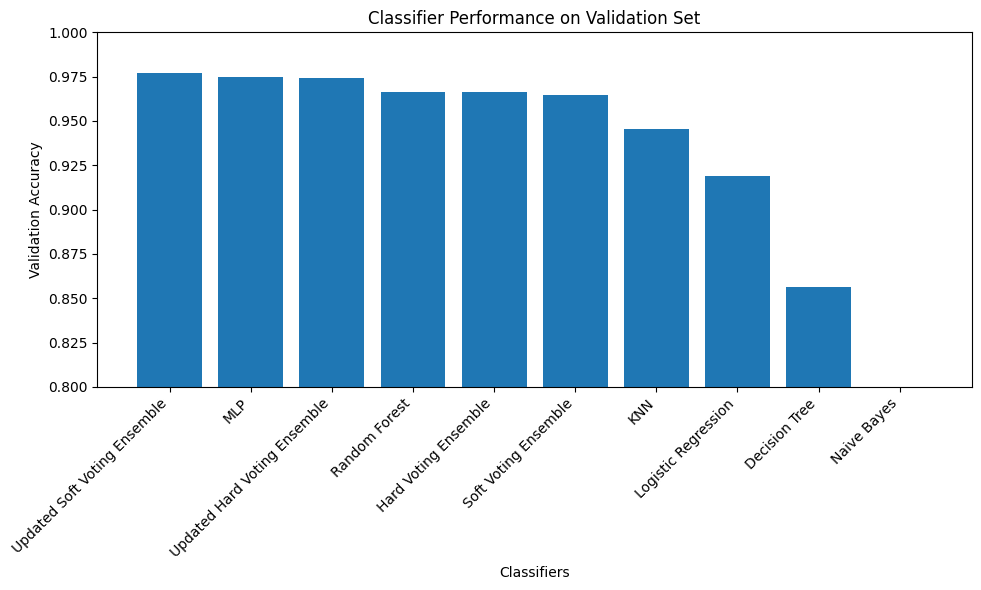

In [18]:
# Create a bar plot of classifier performances
plt.figure(figsize=(10, 6))
names, accuracies = zip(*sorted_performances)
plt.bar(names, accuracies)
plt.title('Classifier Performance on Validation Set')
plt.xlabel('Classifiers')
plt.ylabel('Validation Accuracy')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h3>Now, we have an ensemble model that outperforms all the individual classifiers.</h3>

In [19]:
# Evaluate individual classifiers on test set
print("\nTest Set Performance:")
for name, clf in classifiers.items():
    test_pred = clf.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f"{name} Test Accuracy: {test_accuracy:.4f}")


Test Set Performance:
Random Forest Test Accuracy: 0.9656
Decision Tree Test Accuracy: 0.8550
Logistic Regression Test Accuracy: 0.9198
MLP Test Accuracy: 0.9714
Naive Bayes Test Accuracy: 0.5418
KNN Test Accuracy: 0.9439


In [20]:
# Evaluate soft voting ensemble on test set
soft_test_pred = soft_voting_clf.predict(X_test_scaled)
soft_test_accuracy = accuracy_score(y_test, soft_test_pred)
print(f"Soft Voting Ensemble Test Accuracy: {soft_test_accuracy:.4f}")

Soft Voting Ensemble Test Accuracy: 0.9757


<h3>Soft voting ensemble reduced the error rate of the best indivudual model from about 2.79% to 2.6%, which means about 6.81% less errors.</h3>